## **Ex. No. 17 - USE A NAIVE BAYES MODEL TO CLASSIFY PATIENTS WITH HEART DISEASE**
---
Niranjana A

220301061

III BME - "A"

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading packages.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

#

import math
import random
import os
import time

from numpy import interp

# Disabling warnings:

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Datasets/heart.csv") #https://www.kaggle.com/datasets/data855/heart-disease

In [ ]:
# Styling:

cust_palt = [
    '#111d5e', '#c70039', '#f37121', '#ffbd69', '#ffc93c'
]

plt.style.use('ggplot')

In [ ]:
# Seeding:

def seed_all(seed):

    ''' A function to seed everything for getting stable results and reproducibility'''

    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
seed_all(seed)

In [ ]:
train.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\n'
)

Train data has 14 features, 303 observations.
Train features are:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']



In [ ]:
# Checking null values:

train.isnull().sum().sum()

0

In [ ]:
# Renaming columns.
train.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'condition']

In [ ]:
# Number of unique train observartions:

train.nunique()

,0
age,41
sex,2
chest_pain_type,4
resting_blood_pressure,49
cholesterol,152
fasting_blood_sugar,2
rest_ecg,3
max_heart_rate_achieved,91
exercise_induced_angina,2
st_depression,40


In [ ]:
# Renaming cateorical data for easier understanding:

train['sex'] = train['sex'].map({0:'female',1:'male'})

train['chest_pain_type'] = train['chest_pain_type'].map({3:'asymptomatic', 1:'atypical_angina', 2:'non_anginal_pain', 0:'typical_angina'})

train['fasting_blood_sugar'] = train['fasting_blood_sugar'].map({0:'less_than_120mg/ml',1:'greater_than_120mg/ml'})

train['rest_ecg'] = train['rest_ecg'].map({0:'normal',1:'ST-T_wave_abnormality',2:'left_ventricular_hypertrophy'})

train['exercise_induced_angina'] = train['exercise_induced_angina'].map({0:'no',1:'yes'})

train['st_slope'] = train['st_slope'].map({0:'upsloping',1:'flat',2:'downsloping'})

train['thalassemia'] = train['thalassemia'].map({1:'fixed_defect',0:'normal',2:'reversable_defect'})

train['condition'] = train['condition'].map({0:'no_disease', 1:'has_disease'})
# Masks for easier selection in future:

categorical = [i for i in train.loc[:,train.nunique()<=10]]
continuous = [i for i in train.loc[:,train.nunique()>=10]]


In [ ]:
def ctg_dist(df, cols, hue=None,rows=3, columns=3):

    '''A function for displaying cateorical distribution'''

    fig, axes = plt.subplots(rows, columns, figsize=(16, 12))
    axes = axes.flatten()

    for i, j in zip(df[cols].columns, axes):
        sns.countplot(x=i,
                    data=df,
                    palette=cust_palt,
                    hue=hue,
                    ax=j,
                    order=df[i].value_counts().index)
        j.tick_params(labelrotation=10)

        total = float(len(df[i]))

        j.set_title(f'{str(i).capitalize()} Distribution')


        for p in j.patches:
            height = p.get_height()
            j.text(p.get_x() + p.get_width() / 2.,
                    height + 2,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha='center')

        plt.tight_layout()

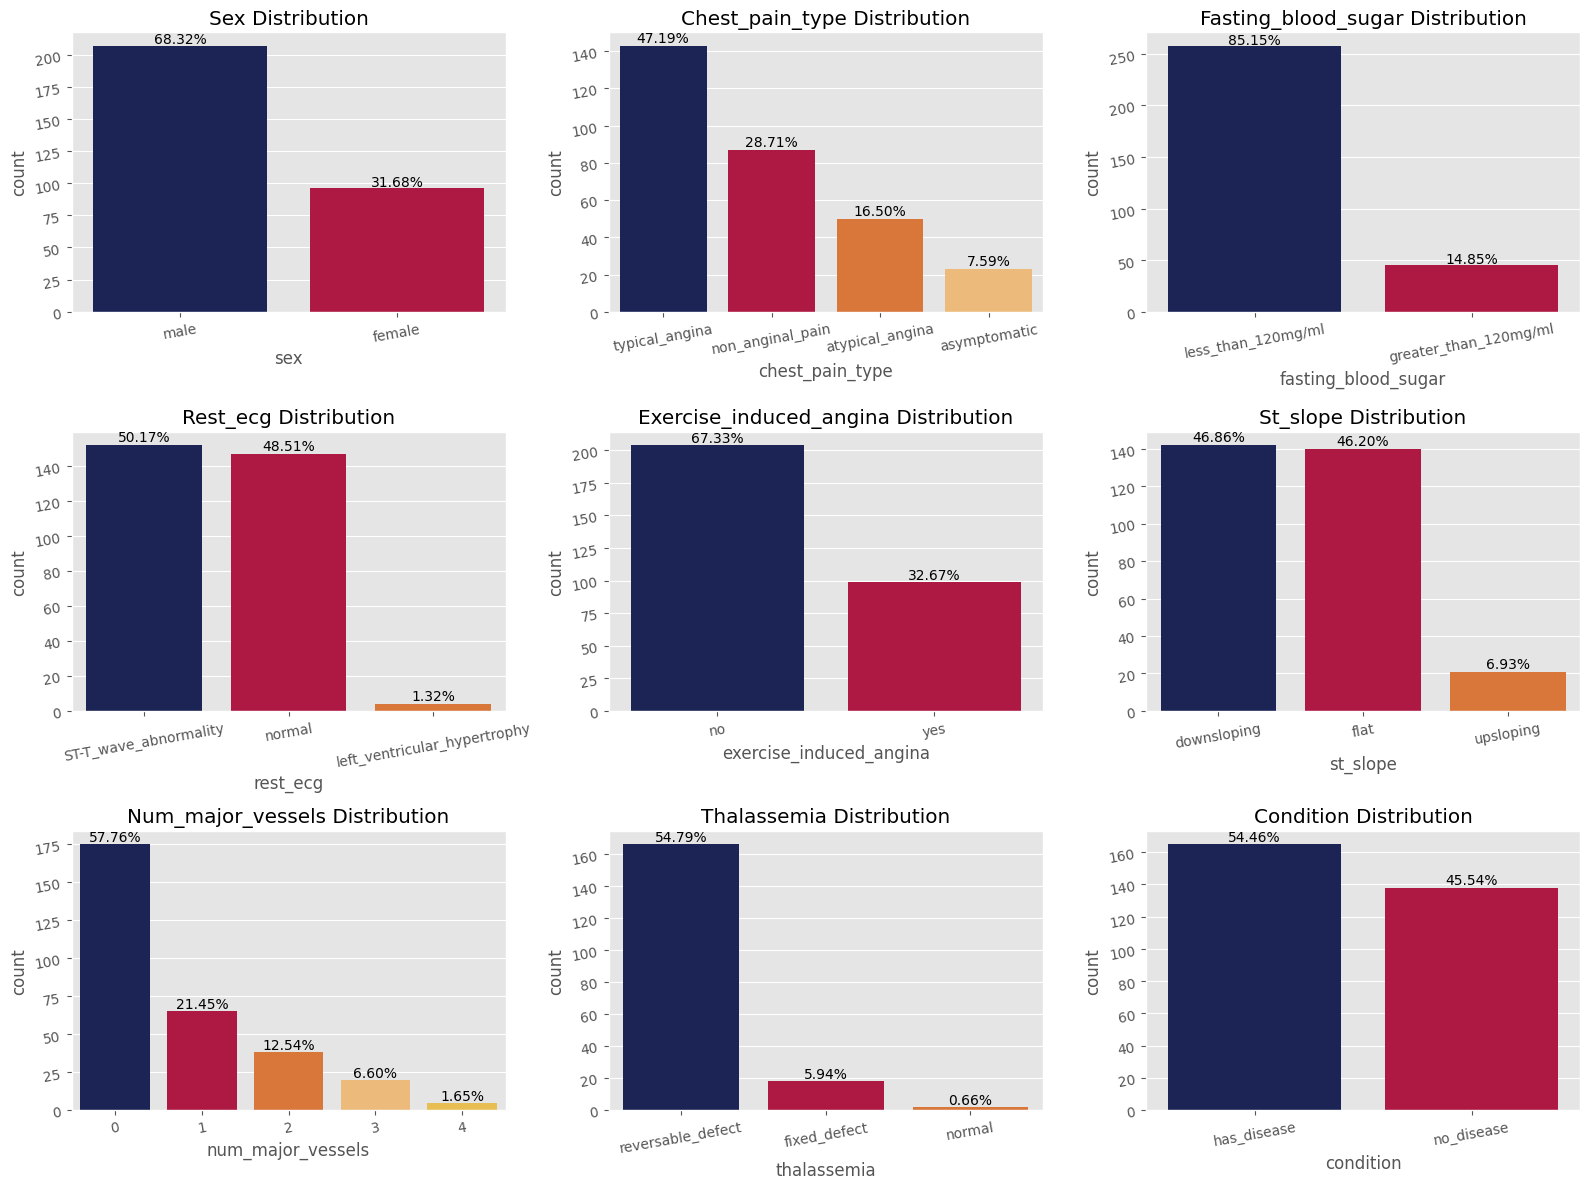

In [ ]:
# Display categorical data:

ctg_dist(train, categorical)

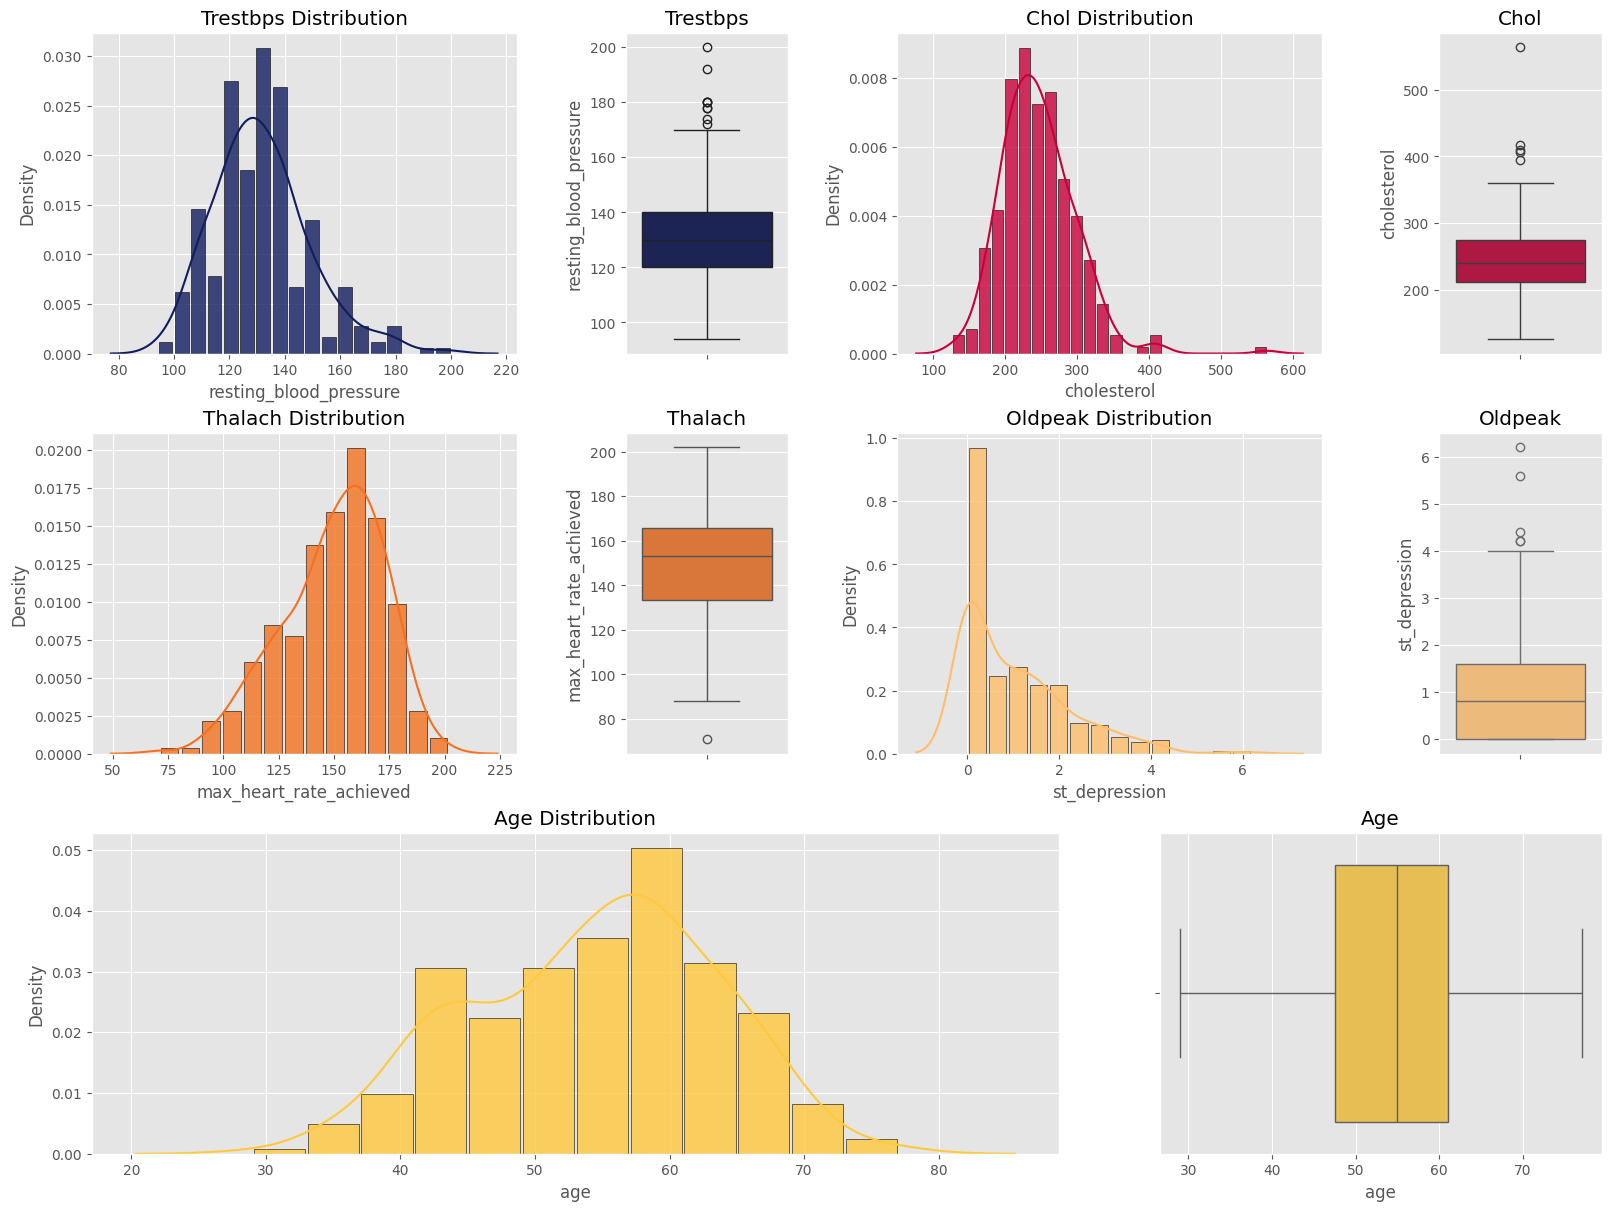

In [ ]:
# Displaying numeric distribution:

fig = plt.figure(constrained_layout=True, figsize=(16, 12))


grid = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

ax1.set_title('Trestbps Distribution')

sns.distplot(train[continuous[1]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[0])

ax15 = fig.add_subplot(grid[0, 2:3])

ax15.set_title('Trestbps')

sns.boxplot(train[continuous[1]], orient='v', color=cust_palt[0])

ax2 = fig.add_subplot(grid[0, 3:5])

ax2.set_title('Chol Distribution')

sns.distplot(train[continuous[2]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[1])

ax25 = fig.add_subplot(grid[0, 5:])

ax25.set_title('Chol')

sns.boxplot(train[continuous[2]], orient='v', color=cust_palt[1])

ax3 = fig.add_subplot(grid[1, :2])

ax3.set_title('Thalach Distribution')

sns.distplot(train[continuous[3]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[2])

ax35 = fig.add_subplot(grid[1, 2:3])

ax35.set_title('Thalach')

sns.boxplot(train[continuous[3]], orient='v', color=cust_palt[2])

ax4 = fig.add_subplot(grid[1, 3:5])

ax4.set_title('Oldpeak Distribution')

sns.distplot(train[continuous[4]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[3])

ax45 = fig.add_subplot(grid[1, 5:])

ax45.set_title('Oldpeak')

sns.boxplot(train[continuous[4]], orient='v', color=cust_palt[3])

ax5 = fig.add_subplot(grid[2, :4])

ax5.set_title('Age Distribution')

sns.distplot(train[continuous[0]],
                 hist_kws={
                 'rwidth': 0.95,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[4])

ax55 = fig.add_subplot(grid[2, 4:])

ax55.set_title('Age')

sns.boxplot(train[continuous[0]], orient='h', color=cust_palt[4])

plt.show()

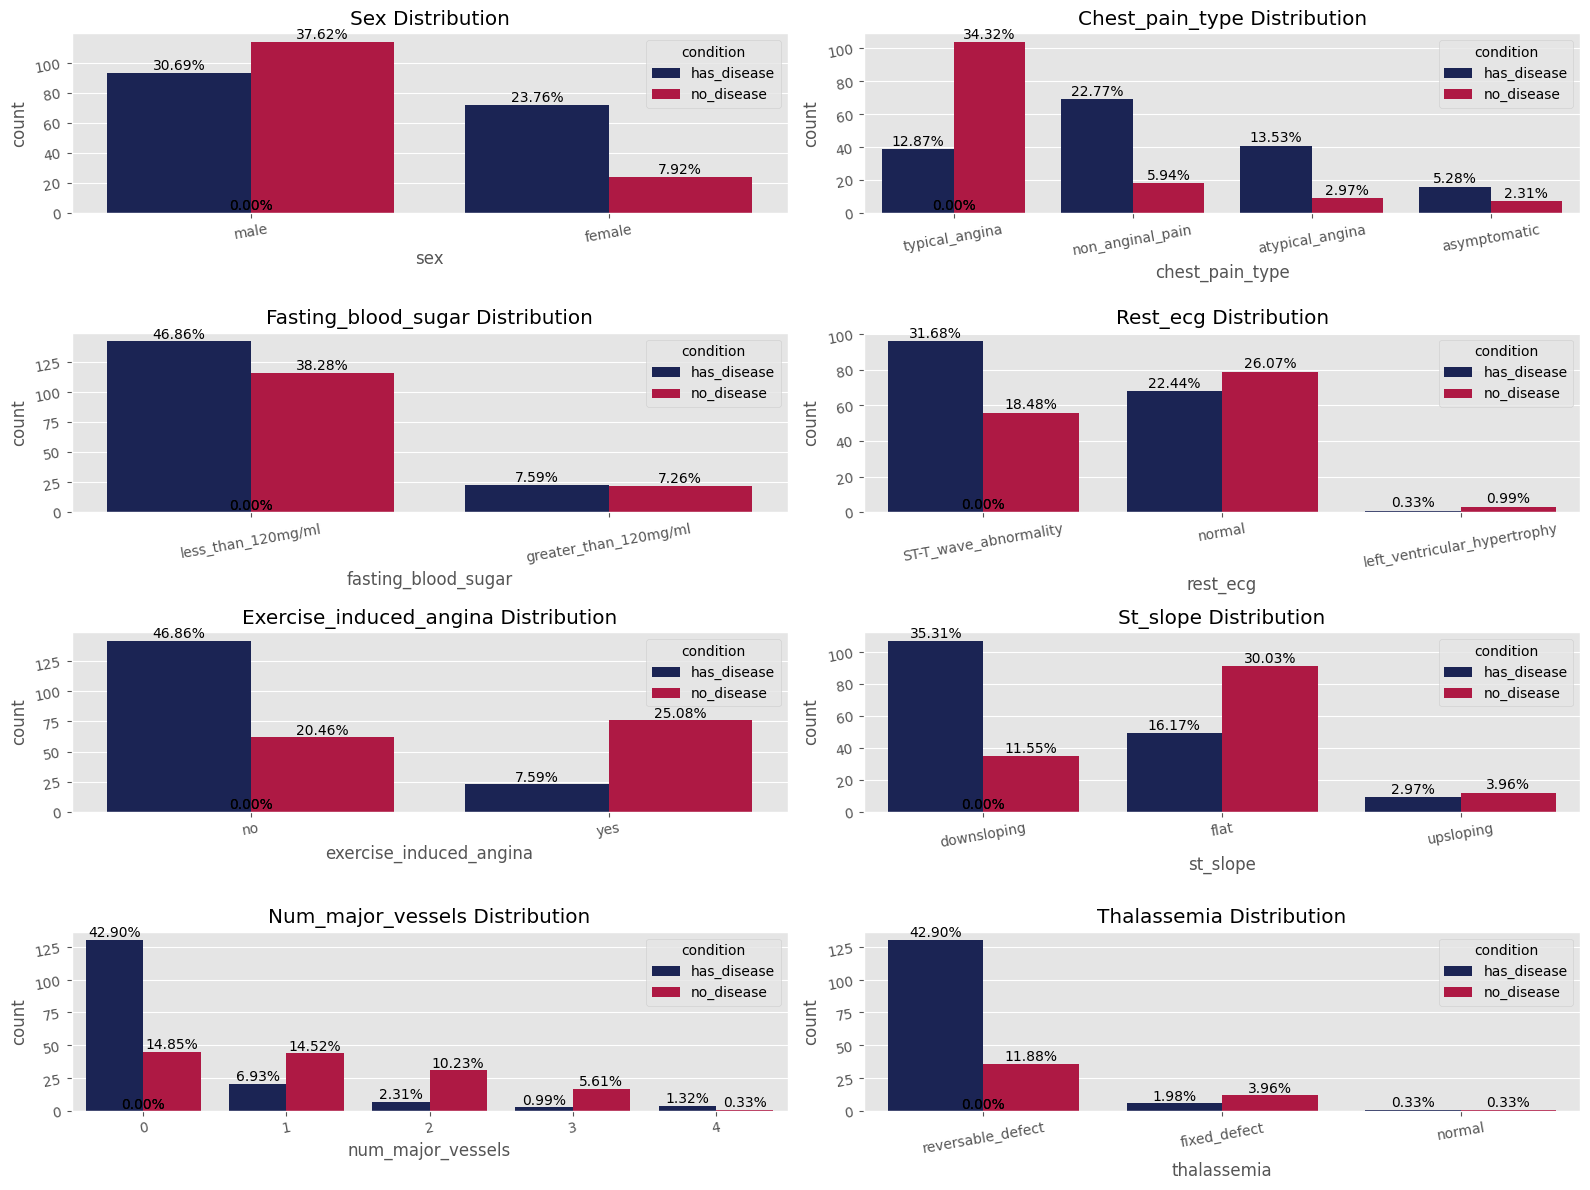

In [ ]:
# Categorical data vs condition:

ctg_dist(train, categorical[:-1], 'condition', 4, 2)

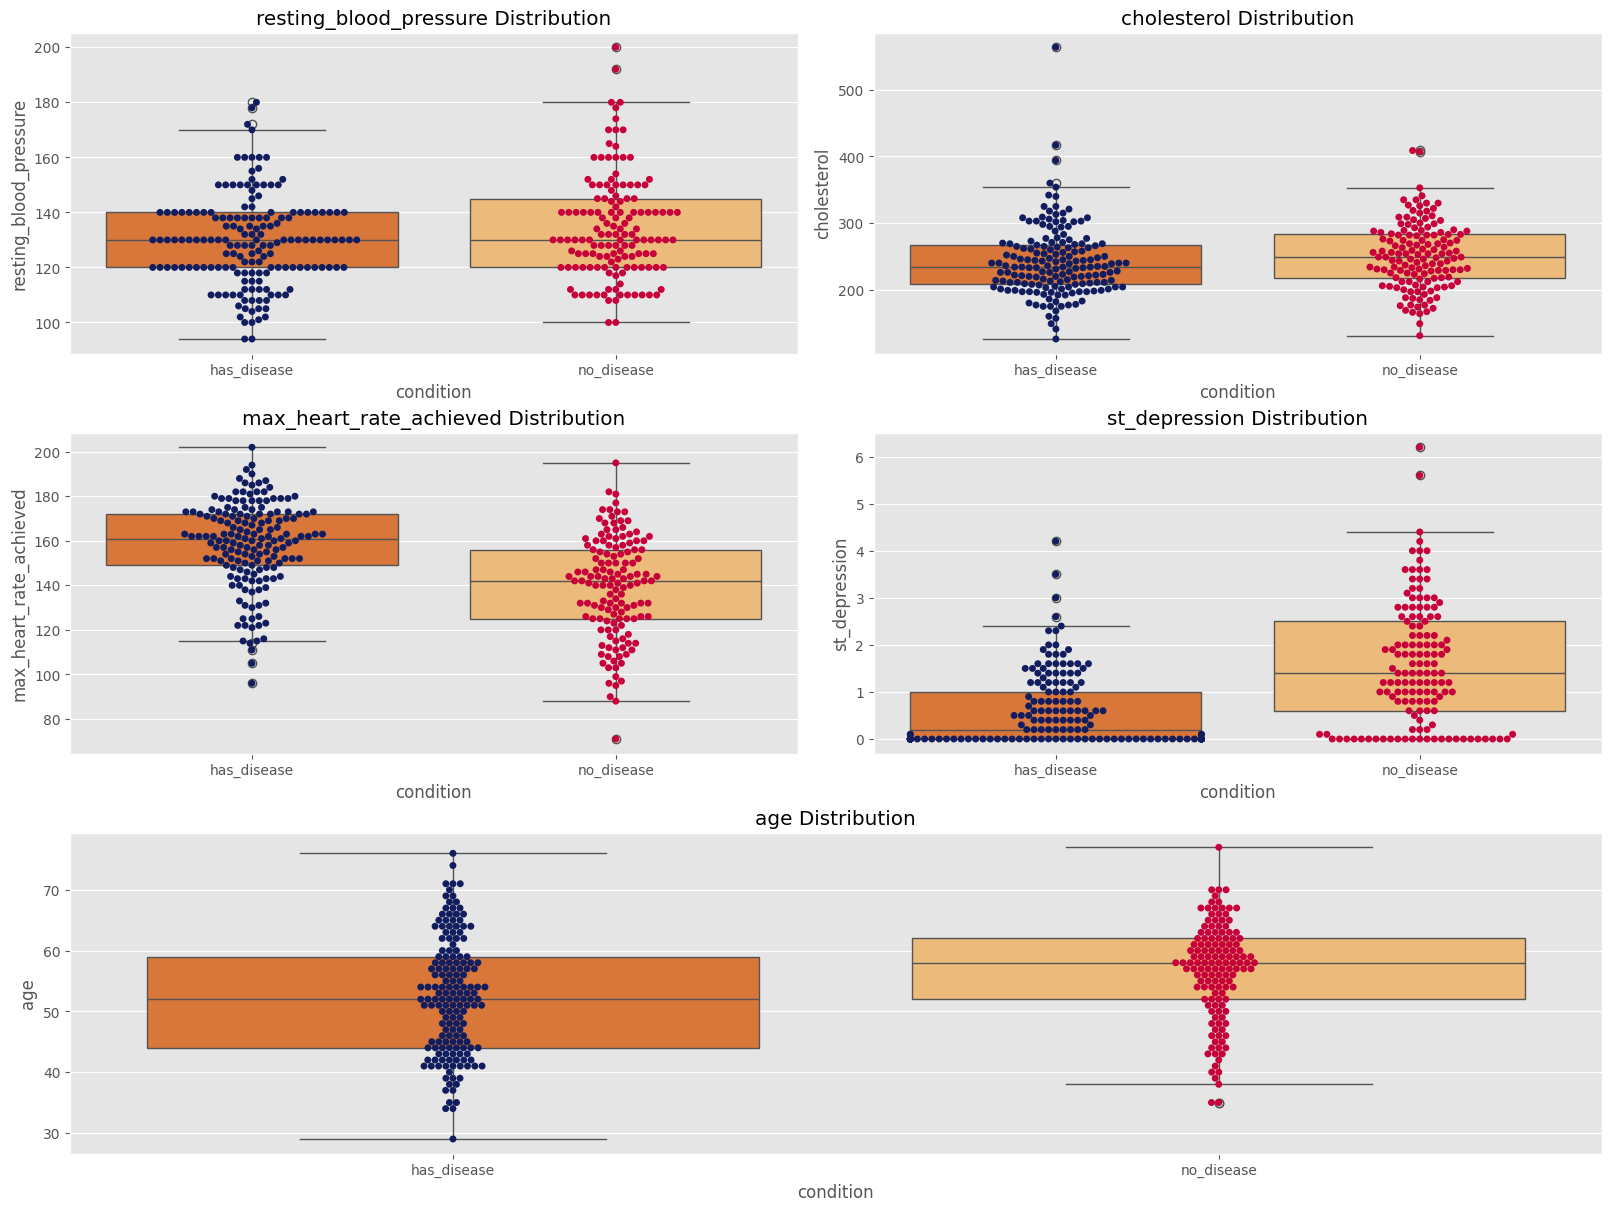

In [ ]:
# Displaying numeric distribution vs condition:

fig = plt.figure(constrained_layout=True, figsize=(16, 12))


grid = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

ax1.set_title('resting_blood_pressure Distribution')

sns.boxplot(x='condition',
                    y='resting_blood_pressure',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax1)
sns.swarmplot(x='condition',
                    y='resting_blood_pressure',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax1)

ax2 = fig.add_subplot(grid[0, 2:])

ax2.set_title('cholesterol Distribution')

sns.boxplot(x='condition',
                    y='cholesterol',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax2)
sns.swarmplot(x='condition',
                    y='cholesterol',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax2)

ax3 = fig.add_subplot(grid[1, :2])

ax3.set_title('max_heart_rate_achieved Distribution')

sns.boxplot(x='condition',
                    y='max_heart_rate_achieved',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax3)
sns.swarmplot(x='condition',
                    y='max_heart_rate_achieved',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax3)

ax4 = fig.add_subplot(grid[1, 2:])

ax4.set_title('st_depression Distribution')

sns.boxplot(x='condition',
                    y='st_depression',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax4)
sns.swarmplot(x='condition',
                    y='st_depression',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax4)

ax5 = fig.add_subplot(grid[2, :])

ax5.set_title('age Distribution')

sns.boxplot(x='condition',
                    y='age',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax5)
sns.swarmplot(x='condition',
                    y='age',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax5)
plt.show()

<Figure size 1600x1000 with 0 Axes>

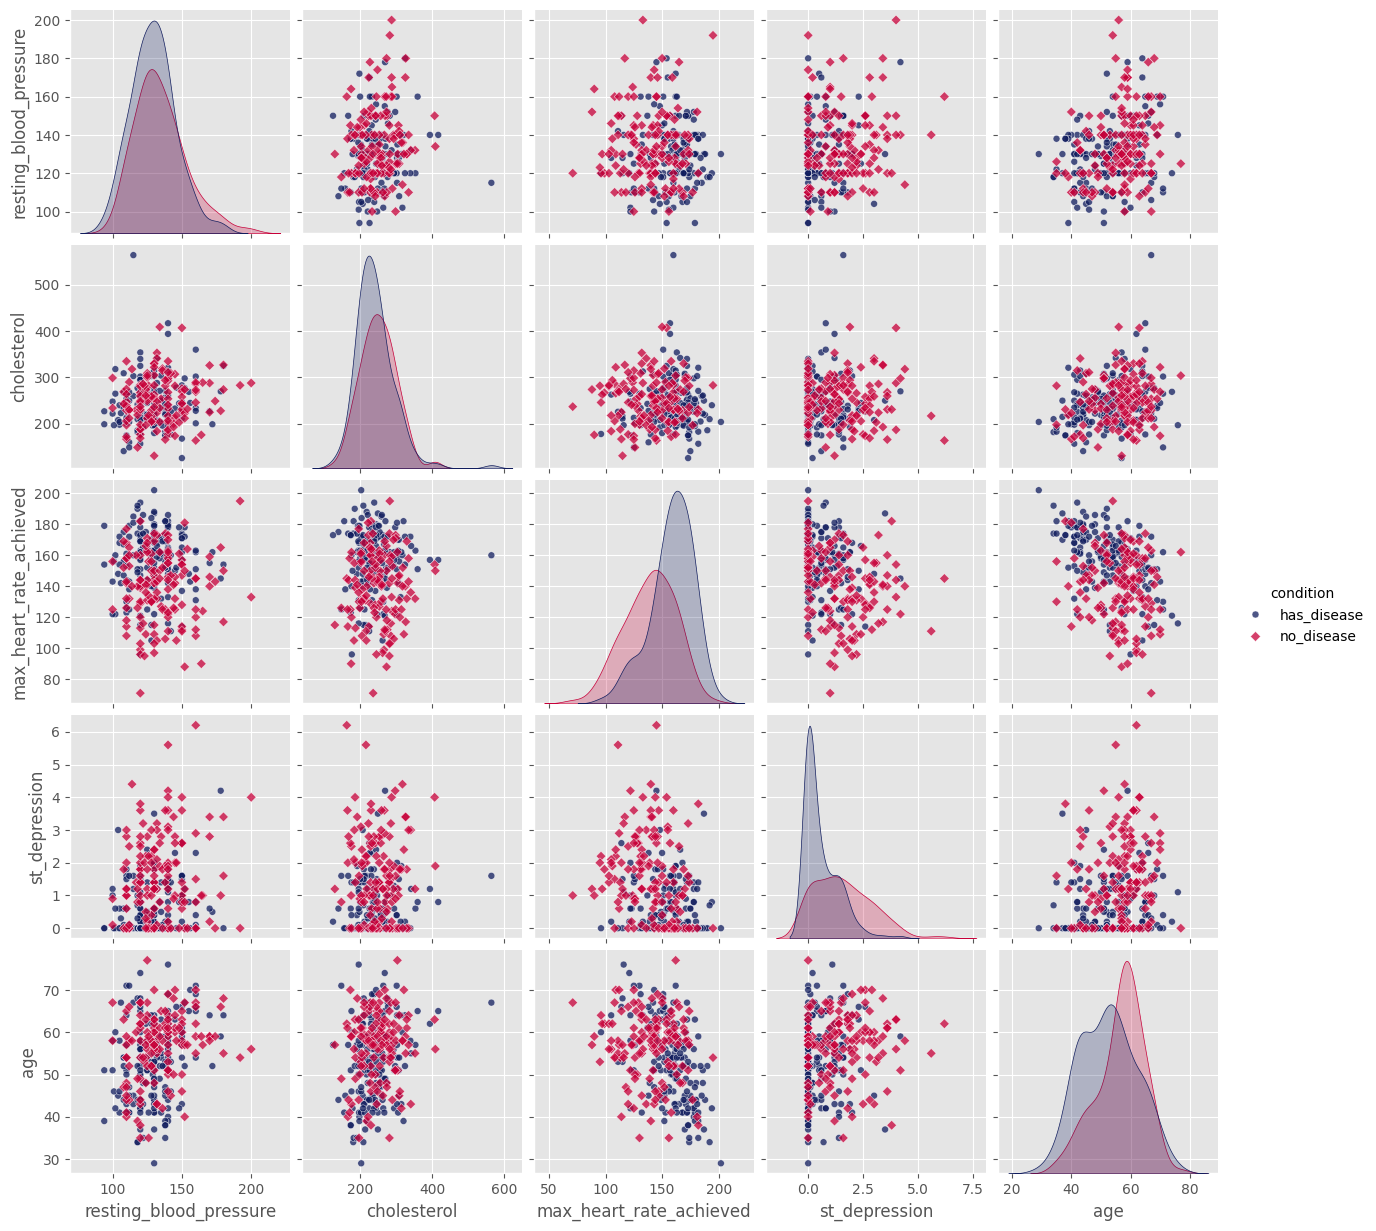

In [ ]:
# Numeric data vs each other and condition:

plt.figure(figsize=(16, 10))
sns.pairplot(train[['resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression','age', 'condition']], hue='condition', palette=cust_palt,
           markers=['o','D'], plot_kws=dict(s=25, alpha=0.75))

plt.show()

In [ ]:
# 3D scatterplot of numeric data:

fig = px.scatter_3d(train, x='cholesterol', y='max_heart_rate_achieved', z='age', size='st_depression',
              color='condition', opacity=0.8)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
def ctn_freq(df, cols, xaxi, hue=None,rows=4, columns=1):

    ''' A function for displaying numerical data frequency vs age and condition '''

    fig, axes = plt.subplots(rows, columns, figsize=(16, 12), sharex=True)
    axes = axes.flatten()

    for i, j in zip(df[cols].columns, axes):
        sns.pointplot(x=xaxi,
                      y=i,
                    data=df,
                    palette=cust_palt[:2],
                    hue=hue,
                    ax=j,ci=False)
        j.set_title(f'{str(i).capitalize()} vs. Age')


        plt.tight_layout()

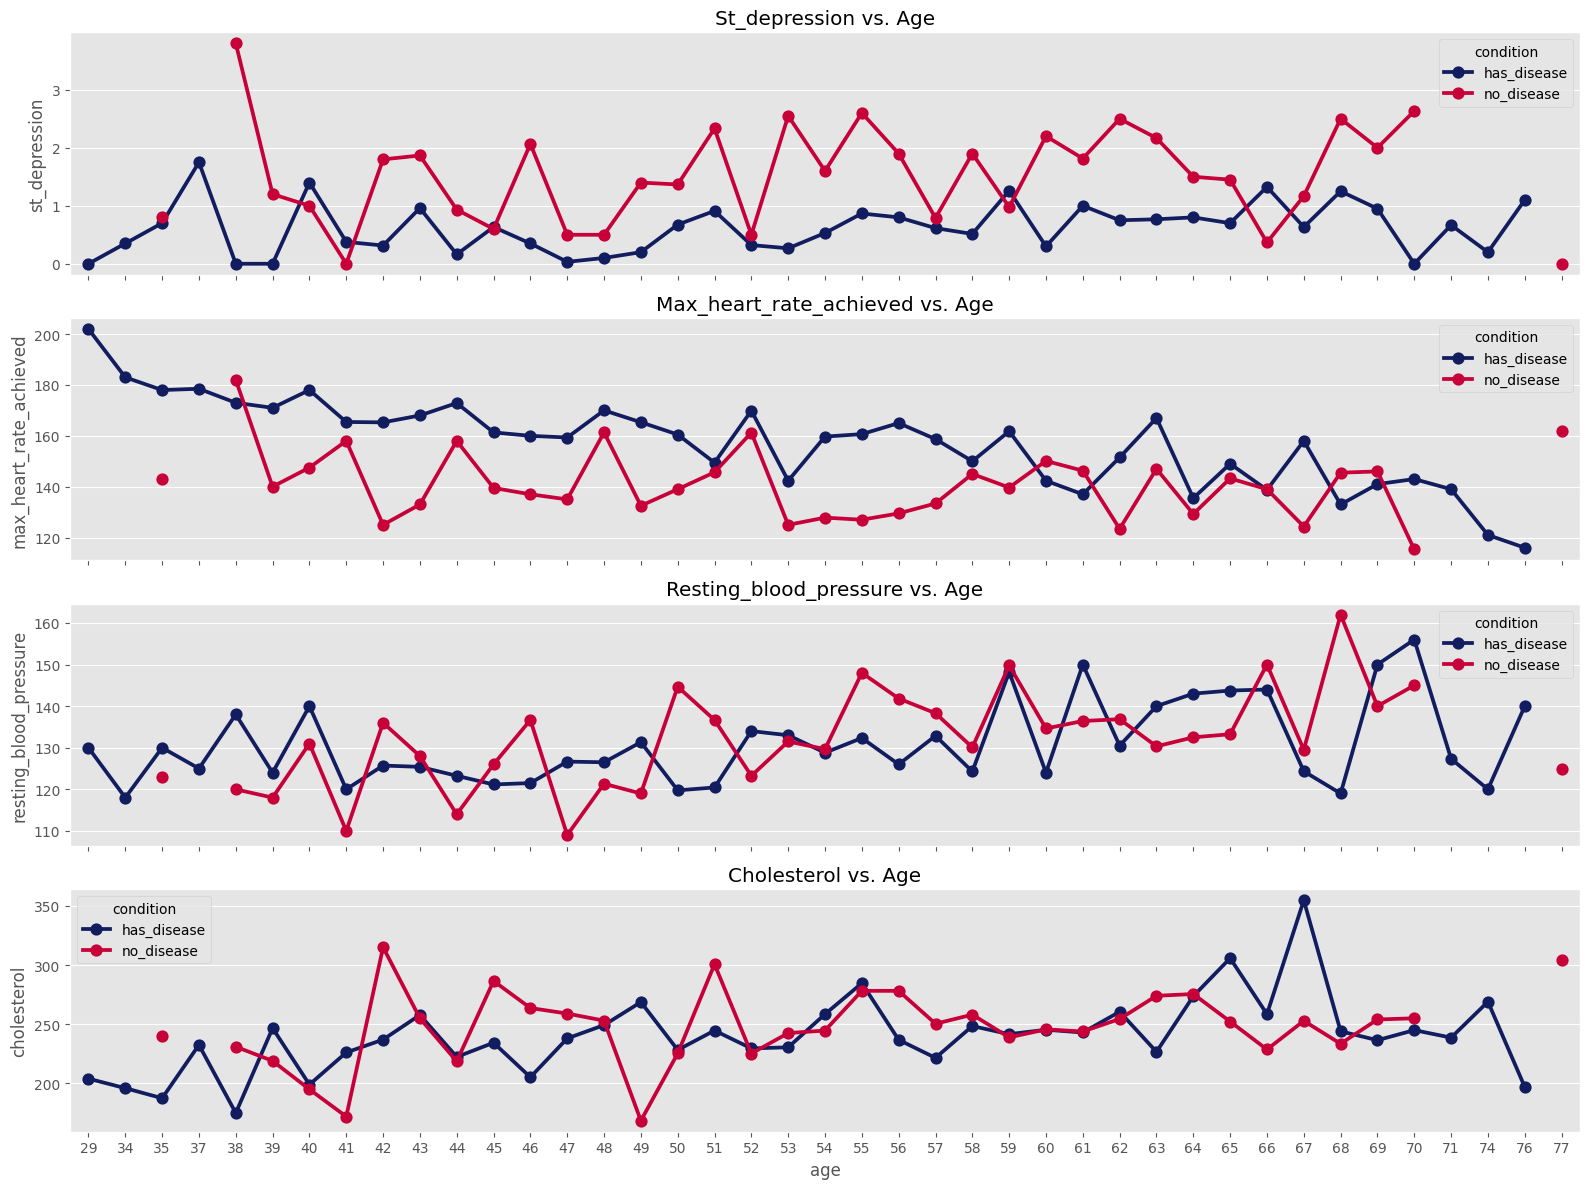

In [ ]:
ctn_freq(train, ['st_depression','max_heart_rate_achieved','resting_blood_pressure','cholesterol'], 'age', hue='condition',rows=4, columns=1)

In [ ]:
#Loading data for heat map correlation
heat_train = pd.read_csv("/content/drive/MyDrive/Datasets/heart_cleveland_upload.csv")

In [ ]:
heat_train.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


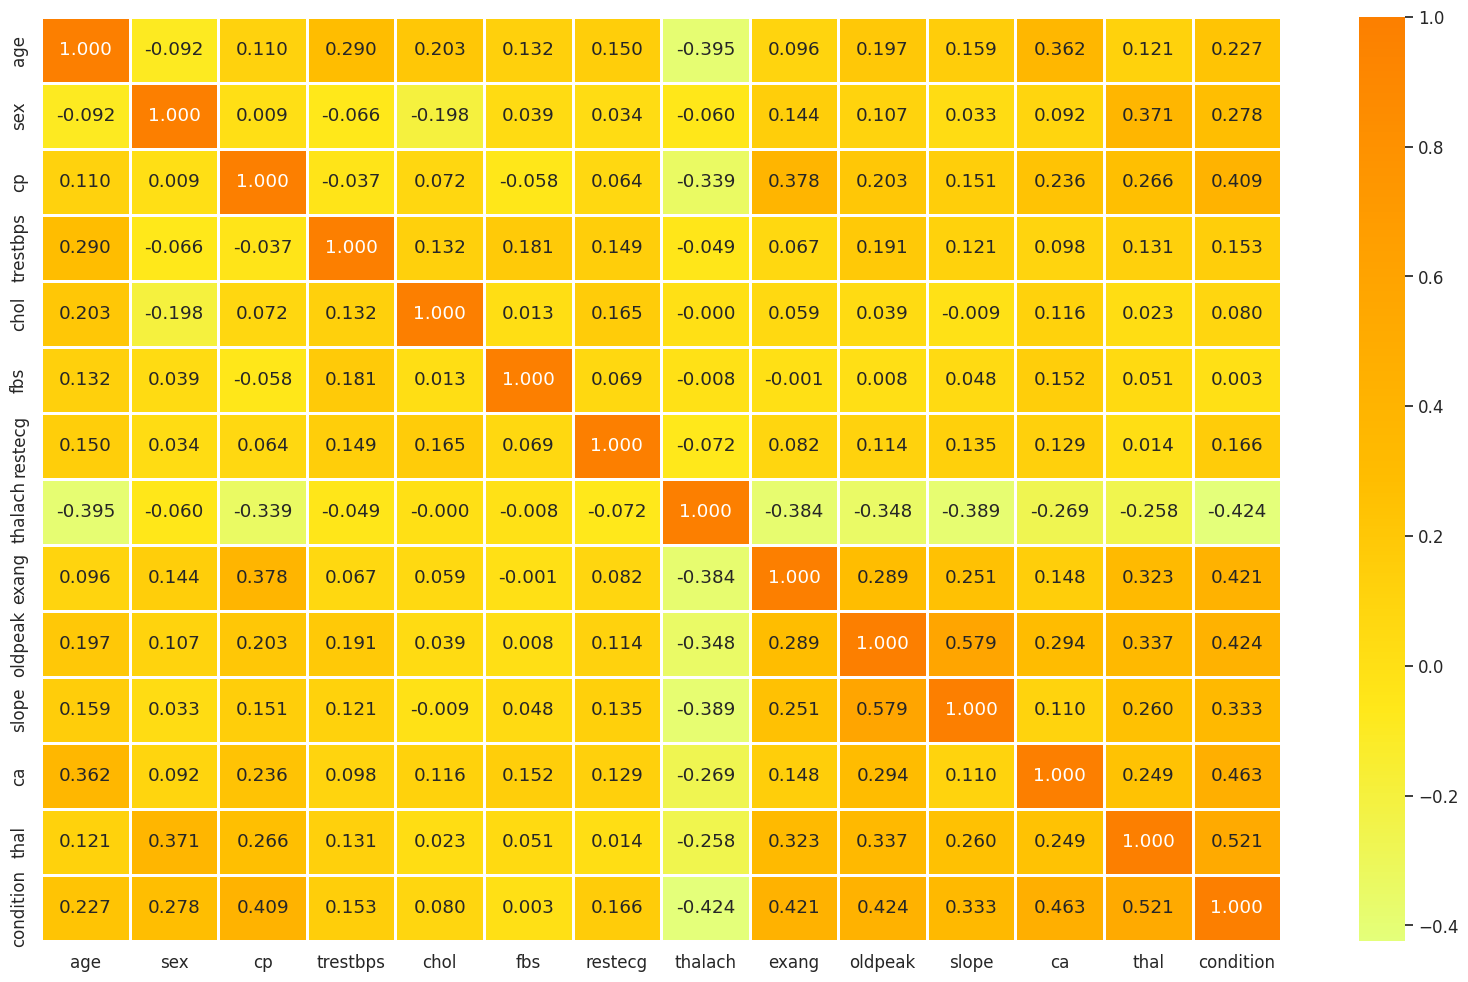

In [ ]:
# Correlation heatmap between variables:

sns.set(font_scale=1.1)
correlation_train = heat_train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='Wistia',
            linewidths=1,
            cbar=True)

plt.show()

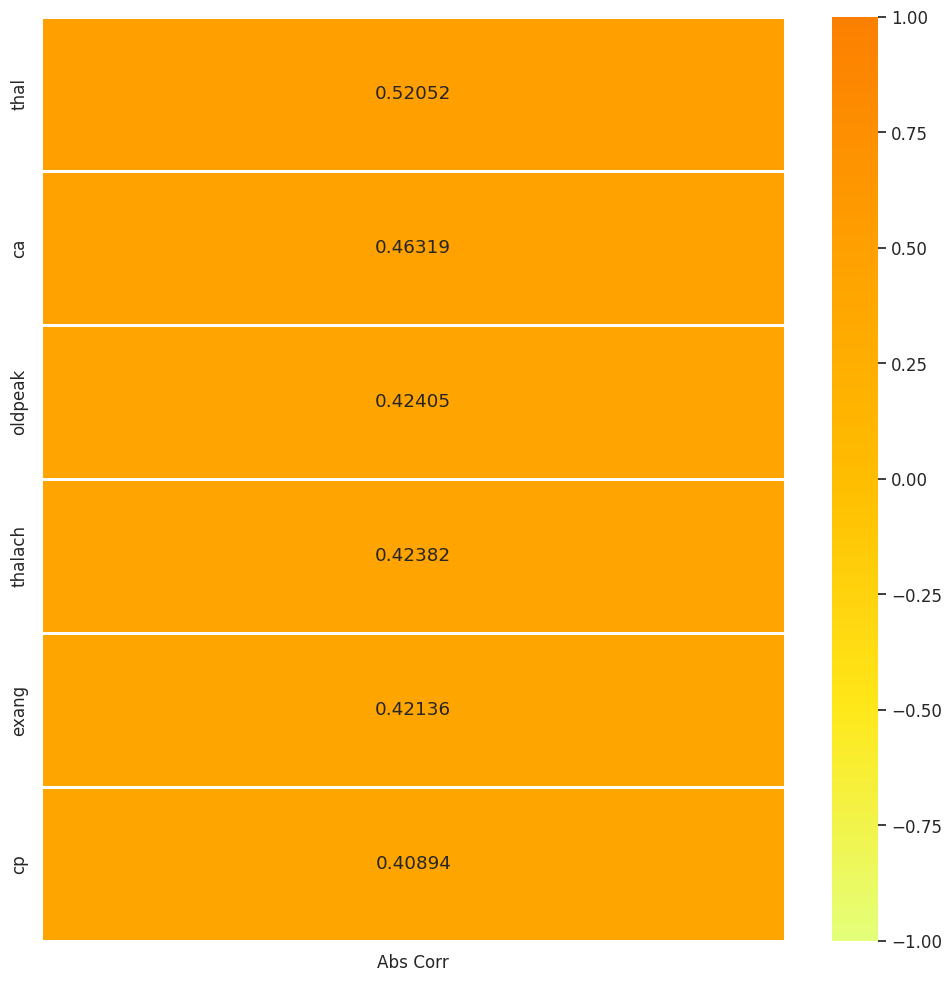

In [ ]:
# Top correlated variables vs condition:

correlations = heat_train.corrwith(heat_train['condition']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.35], cmap='Wistia', annot=True, vmin=-1, vmax=1,linewidths=1,fmt='.5f', ax=ax);

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/heart_cleveland_upload.csv')

# Split the data into features (X) and target (y)
X = data.drop(columns=['condition'])
y = data['condition']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Gaussian Naive Bayes model
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8
Precision: 0.7608695652173914
Recall: 0.8333333333333334
F1 Score: 0.7954545454545454
Confusion Matrix:
 [[37 11]
 [ 7 35]]


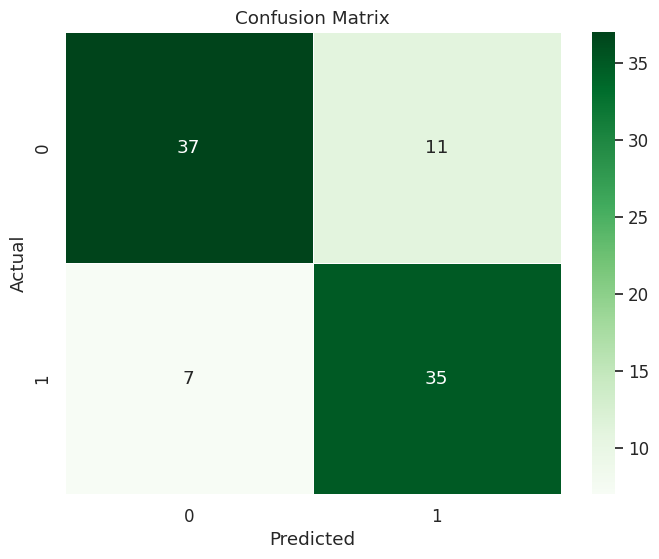

In [ ]:
# Confusion matrix
heart_confusion = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(heart_confusion, annot=True, fmt='d', cmap='Greens', linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()